In [1]:
import numpy as np
import scipy
import mat73
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import sklearn
from sklearn.decomposition import PCA

from matplotlib.animation import FuncAnimation
from PIL import Image

In [2]:
def getXStackAve(byCue, cues):
    for cue in cues:
        Xs = byCue[cue]
        #print(Xs.shape)
        Xs = np.reshape(Xs,(Xs.shape[0],Xs.shape[1]*Xs.shape[2]))
        #print(Xs.shape)
        if cue == cues[0]:
            stack = np.mean(Xs,axis=0)
            stack = np.expand_dims(stack, axis=0)
            cuestack = [cue] 
        else:
            stackIt = np.mean(Xs,axis=0)
            stackIt = np.expand_dims(stackIt, axis=0)
            stack = np.concatenate((stack,stackIt),axis=0)
            cuestack.append(cue)
        #print(stack.shape)
        #stack = stack - np.mean(stack,axis)
    meanStack = np.mean(stack,axis=0)
    stack = stack #- meanStack
    return stack, cuestack

def unscramble3d(plotPoints):
    orientations = [[0,1],[1,2],[0,2]]
    orders = []
    for orientation in orientations:
        print(orientation)
        angles = []
        for x in plotPoints:
            #angle = np.arctan2(x[0] - midpt[0],x[1] - midpt[1])
            angle = np.arctan2(x[orientation[0]],x[orientation[1]])
            angles.append(angle)
        
        order = list(np.argsort(angles))
        order.append(order[0])
        orders.append(order)
    return orders


In [4]:
sessionPath = '/Users/erinkunz/Desktop/InnerSpeech/'

participantNames = ['T12','T15','T16','T17']
arrayNames = [['ventral6v'],['ventral6v','55b','bothv6v55b'],['ventral6v'],['dorsal6v-v','dorsal6v-d','dorsal6v_combined']]
chanSets = [[np.concatenate((np.arange(0,64),np.arange(128,192)))],[np.concatenate((np.arange(0,64),np.arange(256,320))),np.concatenate((np.arange(128,192),np.arange(384,448))),np.concatenate((np.arange(0,64),np.arange(256,320),np.arange(128,192),np.arange(384,448)))],[np.concatenate((np.arange(64,128),np.arange(320,384)))],[np.concatenate((np.arange(0,64),np.arange(256,320))),np.concatenate((np.arange(64,128),np.arange(320,384))),np.concatenate((np.arange(0,128),np.arange(256,384)))]]

sessions = ['t12.2024.04.11','t15.2024.06.14','t16.2024.07.17','t17.2024.12.09']

behaviorConditions = [[2,5,8,11,14,17,20],[3,6,9,12,15,18,21],[4,7,10,13,16,19,22]]
behaviorNamesP = [['Listening','Attempted','Motoric Inner Speech'],['Attempted','ImaginedListening','Listening'],['Auditory Inner Speech','Mimed','Listening'],['Attempted','ImaginedListening','Listening']]
behaviorIdxP = [[2,0,1],[0,1,2],[1,0,2],[0,1,2]]


In [5]:
plotPointsByPandA = {}
plotPointsByPandACloud = {}
expVarByPandA = {}
expVarByPandACloud = {}

for pIdx, participant in enumerate(participantNames):
    # Load and smooth data
    session = sessions[pIdx]
    
    dat = scipy.io.loadmat(sessionPath + 'Data/interleavedVerbalBehaviors/' + session + '_interleavedVerbalBehaviors_raw.mat')
    arrays = arrayNames[pIdx]
    
    binSize = dat['binSize']

    smoothBins = 10 if binSize==10 else 5 
    analysisWindow = [0,50] if binSize==10 else [0,25]

    features = np.concatenate((dat['binnedTX'], dat['spikePow']), 1)
    features = features.astype(np.float64)
    
    bIdxs = np.array(behaviorIdxP[pIdx])

    # Block mean subtraction
    blockNums = np.unique(dat['blockNum'])
    for b in blockNums:
        loopIdx = np.squeeze(dat['blockNum'] == b)
        features[loopIdx, :] -= np.mean(features[loopIdx, :], axis=0)

    smoothFeat = gaussian_filter1d(features, sigma=smoothBins, axis=0)
    smoothFeat = scipy.stats.zscore(smoothFeat)
    smoothFeat[np.isnan(smoothFeat)] = 1.0

    for arrayIdx in range(len(arrays)):
        chans = chanSets[pIdx][arrayIdx]
        smoothFeatChan = smoothFeat[:, chans]

        # get concatenated trials by cue
        byCue = {}
        for i in range(23):
            if i == 0: # skip donothing 
                continue
            trlIdx = np.where(dat['trialCues'] == i + 1)[0]  # Matlab indexing
            startTimes = np.array(dat['goTrialEpochs'][trlIdx, 0] + analysisWindow[0]).astype(int)
            endTimes = np.array(dat['goTrialEpochs'][trlIdx, 0] + analysisWindow[1]).astype(int)
            if pIdx == 0 and i+1 in [2,5,8,11,14,17,20]:
                startTimes = np.array(dat['delayTrialEpochs'][trlIdx, 0] + analysisWindow[0]).astype(int)
                endTimes = np.array(dat['delayTrialEpochs'][trlIdx, 0] + analysisWindow[1]).astype(int)
            thisXs = np.zeros((len(endTimes), analysisWindow[1] - analysisWindow[0], len(chanSets[pIdx][arrayIdx])))
            for j in range(len(endTimes)):
                thisXs[j, :, :] = smoothFeatChan[startTimes[j]:endTimes[j], :]

            byCue[i + 1] = thisXs  # Matlab indexing

        
        behaviors = [0,1]
        behaviorConditionsIt = []
        for i in range(len(behaviors)):
            newI = np.where(bIdxs==behaviors[i])[0][0]
            behaviorConditionsIt.append(behaviorConditions[newI])
        behaviorConditionsToFit = [item for sublist in behaviorConditionsIt for item in sublist]
        
        # averaged 
        X_all, y_all = getXStackAve(byCue, behaviorConditionsToFit)  
        pca = PCA()
        pca.fit(X_all)
        expVarByPandA[(pIdx, arrayIdx)] = pca.explained_variance_ratio_
        Up = pca.components_
        
        plotPoints = np.zeros((len(behaviorConditionsToFit),3))
        for i,b in enumerate(behaviorConditionsToFit):
            trial = X_all[i]
            proj = Up[0:3, :] @ trial  # Project trial into PCA space
            plotPoints[i, :] = proj 
        plotPointsByPandA[(pIdx, arrayIdx)] = plotPoints
        

<IPython.core.display.Javascript object>


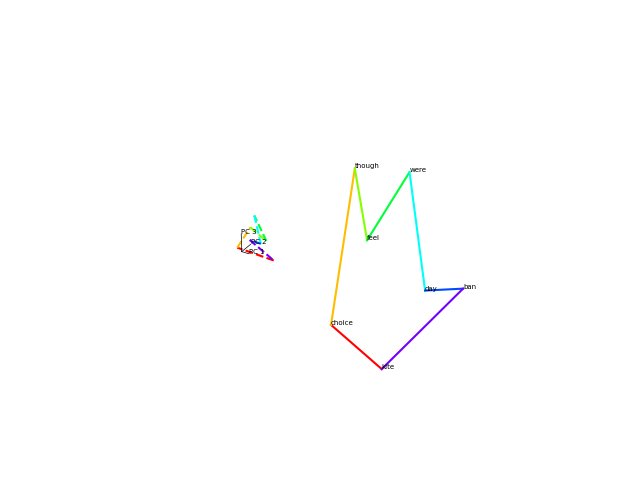

[0, 1]
[1, 2]
[0, 2]


In [7]:
# 3d plot 
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
words = ['ban','choice','day','feel','kite','though','were']

style = ['solid','dashed','dotted']


pIdx = 1 #participant index: 0 - T12, 1 - T15, 2 - T16, 3 - T17
arrayIdx = 1 #array index: in order of arrays for each participant as listed in 'arrayNames'


arrays = arrayNames[arrayIdx]
pp = plotPointsByPandA[(pIdx,arrayIdx)]
orders = unscramble3d(pp[0:7,:]) # overt is first 7 always

ordersForPlotting = [[0],[1,1,1],[1],[1,1,0]]

order = orders[ordersForPlotting[pIdx][arrayIdx]]
order2 = list(np.array(order)+7)
order3 = list(np.array(order)+14)


for l in range(len(order) - 1):
    ax.plot(xs=pp[order[l:l+2],0], ys=pp[order[l:l+2],1],zs=pp[order[l:l+2],2], zdir='z', linestyle=style[0], c=plt.cm.hsv(l/len(order))) # beahvior 1
    ax.plot(xs=pp[order2[l:l+2],0], ys=pp[order2[l:l+2],1],zs=pp[order2[l:l+2],2], zdir='z', linestyle=style[1], c=plt.cm.hsv(l/len(order))) # beahvior 1
    #ax.plot(xs=pp[order3[l:l+2],0], ys=pp[order3[l:l+2],1],zs=pp[order3[l:l+2],2], zdir='z', linestyle=style[2], c=plt.cm.hsv(l/len(order))) # beahvior 1

        #ax.plot(pp[i,order[l],0], pp[i,order[l],1],pp[i,order[l],2],'.',color=plt.cm.hsv(l/len(order)))
            
for j in range(7):
    textx = pp[j,0]
    texty = pp[j,1]
    textz = pp[j,2]
    ax.text(textx,texty,textz,words[j],fontsize=5)
    
    
    
sizeAx=4
transX = 0
transY = 0
transZ = 0
ax.plot([transX, transX],[transY, transY],[transZ, transZ+ sizeAx],'k',linewidth=0.5)
ax.text(transX,transY,transZ + sizeAx,'PC 3',fontsize=5)
ax.plot([transX, transX],[transY, transY+sizeAx],[transZ, transZ],'k',linewidth=0.5)
ax.text(transX,transY+sizeAx,transZ,'PC 2',fontsize=5)
ax.plot([transX, transX+sizeAx],[transY, transY],[transZ, transZ],'k',linewidth=0.5)
ax.text(transX+sizeAx,transY,transZ,'PC 1',fontsize=5)
ax.axis('off')
plt.show()